# Network Engineering in the AI Era

## Module 4.2 - Introduction to Agentic AI

Welcome to this module on Agentic AI using LangGraph!
In this notebook, we'll explore what agents are, how they operate, and build a practical example of an AI agent that can help with network configuration tasks.

### What are AI Agents?

AI agents are autonomous or semi-autonomous systems that can:

- Perceive their environment through inputs and context
- Process and reason about information
- Make decisions and plan multi-step actions
- Execute tasks by using tools and APIs
- Learn from feedback and improve over time

Unlike simple LLM applications that respond to single prompts, agents maintain state, make sequential decisions, and take actions to accomplish complex tasks.

### Key Components of AI Agents

- **Memory**: Ability to store and recall information from previous interactions
- **Tools**: Functions or APIs that the agent can use to interact with external systems
- **Planning**: Ability to break down complex tasks into manageable steps
- **Reasoning**: Capability to make decisions based on available information
- **Reflection**: Ability to evaluate performance and adjust strategies

### LangGraph: Building Stateful Multi-Agent Systems

LangGraph extends LangChain by providing a framework for creating stateful agents with:

- A graph structure where nodes represent different agent states
- Tools for managing transitions between states
- Methods for orchestrating complex workflows with multiple agents

Let's start by installing the necessary libraries:

In [ ]:
!pip install langchain langchain-anthropic langchain-aws langchain-community langgraph langsmith

### Setting Up Our Environment

In order to use LangGraph, we need to setup an llm chain. We will use ChatBedrock since our inference endpoints are hosted on Bedrock.
We will be use the Claude 3.7 model from Anthropic. This is one of the most advanced models available today.

In [2]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    temperature=0,
    region="us-east-1",
)

### Building Our Agent's Components

Our graph will have a single agent (the assistant) and some available tools.

Let's start by defining the tools, and begin with our **Policy Lookup Tool**.

This tool will take the markdown document `acme_guidelines.md` and will split it using the MarkdownHeaderTextSplitter (the same one we learned about on our previous module) and will store the resulting documents in a `InMemoryVectorStore`.
This `InMemoryVectorStore` is no different than any other vector storage databases, it won't be used in a production environment but it is useful for training purposes.

The lookup_policy tool once called, will do a similarity search on the documents stored in the `InMemoryVectorStore` and will return the most similar document to the query.

In [3]:
from typing import Annotated
from langchain_aws import BedrockEmbeddings
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.document_loaders import TextLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter

embeddings = BedrockEmbeddings(
    model_id="amazon.titan-embed-text-v2:0", region_name="us-east-1"
)

loader = TextLoader("acme_guidelines.md")
documents = loader.load()
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
]
md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
md_splits = []
for document in documents:
    md_splits.extend(md_splitter.split_text(document.page_content))

vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(md_splits)


@tool
def lookup_policy(
    query: Annotated[str, "The query to look for in the company policies."],
) -> str:
    """
    Consult the configuration guidelines.
    Use this before making any network changes performing other 'write' events.
    """
    docs = vector_store.similarity_search(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs])

Now that we have done that, let's proceed with creating a tool that will allow the agent to configure devices. In this example, our tool will simulate sending the configuration to a device, and will instead print the configuration to the console. In a real-world scenario, you would replace this with actual code that sends the configuration to a device for example via RESTCONF or NETCONF.

In [4]:
from typing import Annotated

import httpx
from langchain_core.tools import tool

devices = {
    "CTG-EDGE-001": {
        "hostname": "devnetsandboxiosxe.cisco.com",
        "username": "admin",
        "password": "C1sco12345",
    }
}
# hostname = "devnetsandboxiosxe.cisco.com"
# username = "admin"
# password = "C1sco12345"

headers = {
    "Content-Type": "application/yang-data+json",
    "Accept": "application/yang-data+json",
}


@tool
def configure_device(
    device_name: Annotated[str, "The name of the device to configure."],
    interface_name: Annotated[
        str,
        "The interface name to apply the configuration to. E.g., 'Loopback100'",
    ],
    interface_description: Annotated[str, "The description to set for the interface."],
    interface_ipv4_address: Annotated[
        str, "The IPv4 address to assign to the interface. E.g., 192.168.1.1"
    ],
    interface_ipv4_subnet_mask: Annotated[
        str, "The IPv4 subnet mask to assign to the interface. E.g., 255.255.255.0"
    ],
) -> bool:
    """Use this tool to configure the interface of a device."""
    hostname = devices[device_name]["hostname"]
    username = devices[device_name]["username"]
    password = devices[device_name]["password"]
    uri = "/restconf/data/ietf-interfaces:interfaces"
    payload = {
        "ietf-interfaces:interface": {
            "name": interface_name,
            "description": interface_description,
            "type": "iana-if-type:softwareLoopback",
            "enabled": True,
            "ietf-ip:ipv4": {
                "address": [
                    {
                        "ip": interface_ipv4_address,
                        "netmask": interface_ipv4_subnet_mask,
                    }
                ]
            },
        }
    }
    response = httpx.post(
        f"https://{hostname}/{uri}",
        auth=(username, password),
        headers=headers,
        json=payload,
        verify=False,
    )

    response.raise_for_status()
    return response.text

Let's create an array that will contain the list of tools that will be available to our agent. The first tool we'll define is the policy lookup tool. This tool will allow the agent to look up network policies in the knowledge base.

In [5]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda


def handle_tool_error(state) -> dict:
    """Handle the error from the tool."""
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


available_tools = [
    lookup_policy,
    configure_device,
]

Let's create our assistant agent that will have access to all the available tools. We'll define the agent as a class. This will allow us to easily add more tools in the future if needed.

In [6]:
from datetime import datetime

from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)
from langchain_core.messages import HumanMessage
from langchain_core.runnables import Runnable, RunnableConfig
from langgraph.graph import MessagesState

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(
            "You are a helpful customer support assistant for ACME Service Provider. "
            "Use the provided tools to create resources or to search for procedures, company policies, and other information to assist the user's queries. "
            "When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If a search comes up empty, expand your search before giving up."
            "\nCurrent time: {time}.",
        ),
        MessagesPlaceholder("messages"),
    ]
).partial(time=datetime.now)


class Assistant:
    """Assistant node for the graph."""

    def __init__(self):
        """Initialize the assistant."""
        self.runnable: Runnable = primary_assistant_prompt | llm.bind_tools(
            available_tools
        )

    def __call__(self, state: MessagesState, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [
                    HumanMessage(content="Respond with a real output.")
                ]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

Building the Agent Graph
Now, let's connect all these components into a graph using LangGraph:

In [7]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode

# Create the graph
workflow = StateGraph(MessagesState)

# Add nodes: these do the work
workflow.add_node("assistant", Assistant())
workflow.add_node(
    "tools",
    ToolNode(available_tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)],
        exceptions_to_handle=(httpx.RequestError,),
        exception_key="error",
    ),
)

# Define edges: these determine how the control flow moves
workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("tools", "assistant")

graph = workflow.compile()


Let's visualize our graph to see how the nodes are connected:

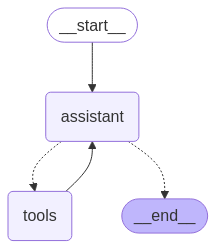

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

Using Our Network Configuration Agent
Let's create a function to interact with our agent:

Example Usage
Let's test our agent with a few examples. Let's begin with asking our agent the following: **I need to create a new VLAN for my database server.**

In [26]:
from fastapi.encoders import jsonable_encoder
import rich
from langchain_core.messages import HumanMessage


for event in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Configure interface Loopback101 on device CTG-EDGE-001 with IPv4 address 10.1.2.1/30, this interface will connect to BOG-CORE-001."
            )
        ]
    },
    stream_mode="updates",
):
    for _, message_or_messages in event.items():
        if isinstance(message_or_messages["messages"], list):
            for message in message_or_messages["messages"]:
                rich.print(message.pretty_repr())
        else:
            rich.print(message_or_messages["messages"].pretty_repr())


================================== Ai Message ==================================

I'll help you configure the Loopback101 interface on device CTG-EDGE-001. Before making any network changes, I 
should check our company policies regarding interface configurations.
Tool Calls:
  lookup_policy (toolu_bdrk_01NeLwaQguR62QEHZaTTaBGZ)
 Call ID: toolu_bdrk_01NeLwaQguR62QEHZaTTaBGZ
  Args:
    query: loopback interface configuration

================================= Tool Message =================================
Name: lookup_policy

1. Interfaces must have a description that matches the following convention: <type>_<speed>_<peer_id>, where `type`
is `L2` for switches interfaces, `L3` for routed interfaces and `PC` to interfaces member of a port-channel  
```
interface ethernet1/1
no switchport
description L3_10G_DMZ Router
ip address 10.1.2.254/24
```

The following document states the configuration policies of the devices of the ACME company

================================== Ai Message ==================================

Now I'll check for any specific policies related to loopback interfaces:
Tool Calls:
  lookup_policy (toolu_bdrk_01QitKJgyYbty2jhsvfchUR2)
 Call ID: toolu_bdrk_01QitKJgyYbty2jhsvfchUR2
  Args:
    query: loopback interface naming convention

================================= Tool Message =================================
Name: lookup_policy

1. Interfaces must have a description that matches the following convention: <type>_<speed>_<peer_id>, where `type`
is `L2` for switches interfaces, `L3` for routed interfaces and `PC` to interfaces member of a port-channel  
```
interface ethernet1/1
no switchport
description L3_10G_DMZ Router
ip address 10.1.2.254/24
```

1. Routable addresses used on physical Interfaces (E.g: Ethernet 1/2), Port-Chanels (port-channel1) or SVI 
Interfaces must be taken from the CIDR 10.1.0.0/8  
Example:
This is a valid interface configuration
```
interface vlan 123
no switchport
ip address 10.1.1.254/24
```  
2. IP Addresses assigned to Router IDs (RID) of routing protocols such as OSPF, EIGRP or BGP must be taken from the
CIDR 172.20.0.0/16  
Example:
This is a valid OSPF process configuration  
```
router ospf OSPF1
router-id  172.1.1.5
```

================================== Ai Message ==================================

Based on the company policies, I need to configure the Loopback101 interface with the proper description format and
IP address. Since this is a loopback interface connecting to another device (BOG-CORE-001), I'll use the L3 type in
the description.

Now I'll proceed with configuring the device:
Tool Calls:
  configure_device (toolu_bdrk_01JV9jtEmkNFjxf1iDj4Rsc3)
 Call ID: toolu_bdrk_01JV9jtEmkNFjxf1iDj4Rsc3
  Args:
    device_name: CTG-EDGE-001
    interface_name: Loopback101
    interface_description: L3_LOOPBACK_BOG-CORE-001
    interface_ipv4_address: 10.1.2.1
    interface_ipv4_subnet_mask: 255.255.255.252

================================= Tool Message =================================
Name: configure_device

================================== Ai Message ==================================

I've successfully configured the Loopback101 interface on device CTG-EDGE-001 with the following settings:

- Device: CTG-EDGE-001
- Interface: Loopback101
- Description: L3_LOOPBACK_BOG-CORE-001
- IPv4 Address: 10.1.2.1
- Subnet Mask: 255.255.255.252 (equivalent to /30 as requested)

The configuration has been applied according to ACME company policies, using the proper description format for a 
Layer 3 interface and an IP address from the allowed 10.1.0.0/8 range.

Is there anything else you'd like me to help you with regarding this configuration?

Let's now verify that the requested interface has been configured. We are going to do this directly using httpx to make a GET request to the /interfaces endpoint of our device.

In [27]:
import httpx

hostname = devices["CTG-EDGE-001"]["hostname"]
username = devices["CTG-EDGE-001"]["username"]
password = devices["CTG-EDGE-001"]["password"]
uri = "/restconf/data/ietf-interfaces:interfaces/interface=Loopback101"

response = httpx.get(
    f"https://{hostname}/{uri}",
    auth=(username, password),
    headers=headers,
    verify=False,
)
print(response.text)

{
  "ietf-interfaces:interface": [
    {
      "name": "Loopback101",
      "description": "L3_LOOPBACK_BOG-CORE-001",
      "type": "iana-if-type:softwareLoopback",
      "enabled": true,
      "ietf-ip:ipv4": {
        "address": [
          {
            "ip": "10.1.2.1",
            "netmask": "255.255.255.252"
          }
        ]
      },
      "ietf-ip:ipv6": {
      }
    }
  ]
}



Let's delete the recently created interface to avoid any issues in the future.

In [28]:
import httpx

hostname = devices["CTG-EDGE-001"]["hostname"]
username = devices["CTG-EDGE-001"]["username"]
password = devices["CTG-EDGE-001"]["password"]
interface_to_delete = "Loopback101"
uri = f"/restconf/data/ietf-interfaces:interfaces/interface={interface_to_delete}"

# Make DELETE request to remove the interface
response = httpx.delete(
    f"https://{hostname}/{uri}",
    auth=(username, password),
    headers=headers,
    verify=False,
)
print(response.text)